In [1]:
from __future__ import division
%matplotlib inline
import csv
import sys
import os
import traceback
import json
import numpy as np
import pandas as pd
import scipy.io as sio
from tabulate import tabulate
from matplotlib import pyplot as plt
from collections import defaultdict, Counter

from helper_functions import getListOfFiles, getCSV, getStatistics, remap_interval

## Recomposing signal

In [2]:
csv_dir = "./data"
files = getListOfFiles(csv_dir, ".csv")
print ">> {} CSV Files found:\n".format(len(files))
print json.dumps(files)

>> 34 CSV Files found:

["_2016-11-23-18-49-13_exp1_Player.csv", "_2016-11-23-18-49-13_exp2_Player.csv", "_2016-11-23-18-49-13_exp3_Player.csv", "_2016-11-23-18-49-13_exp4_Player.csv", "_2016-11-23-18-49-13_exp5_Player.csv", "_2016-11-24-15-43-37_exp1d_Player.csv", "_2016-11-24-15-43-37_exp2d_Player.csv", "_2016-11-24-15-43-37_exp3d_Player.csv", "_2016-11-24-15-43-37_exp4d_Player.csv", "_2016-11-24-15-43-37_exp5d_Player.csv", "_2016-11-24-15-43-37_exp6d_Player.csv", "_2016-11-24-16-23-29_expa_Player.csv", "_2016-11-24-16-23-29_expb_Player.csv", "_2016-11-24-16-23-29_expc_Player.csv", "_2016-11-24-16-23-29_expd_Player.csv", "_2016-11-24-16-48-48_exp1d_Player.csv", "_2016-11-24-16-48-48_exp2d_Player.csv", "_2016-11-24-16-48-48_exp3d_Player.csv", "_2016-11-24-17-15-38_expa_Player.csv", "_2016-11-24-17-15-38_expb_Player.csv", "_2016-11-24-17-15-38_expc_Player.csv", "_2016-11-24-17-40-06_expb_Player.csv", "_2016-11-26-15-42-51_exp1d_Player.csv", "_2016-11-26-16-05-47_exp1d_Player.csv", "_20

In [3]:
# variable for storing the loaded feature names.
feature_name_map = {
  "time" : "time",
  "Control": "control",
  "High_level": "high_level",
  "Expectation": "expectation",
  "Activity": "activity",
  "/kinect_features/.ci": "ci",
  "/kinect_features/.distance": "distance",
  "/kinect_features/.proximity": "proximity",
  "robogame/imu_state.gyro.x": "gyroX",
  "robogame/imu_state.gyro.y": "gyroY",
  "robogame/imu_state.gyro.z": "gyroZ",
  "robogame/imu_state.linear_acc.x": "accX",
  "robogame/imu_state.linear_acc.y": "accY",
  "robogame/imu_state.linear_acc.z": "accZ"
}

ignore_col_list = [k for k,v in feature_name_map.items() if v is ""]
print "List of ignored topics: {}".format(ignore_col_list)

List of ignored topics: []


In [27]:
##NOTE: IF "TOO MANY VALUES TO UNPACK" ERROR IN THE getCSV METHOD, RESTART THE KERNEL. SOMETHING MUST BE WRONG WITH
# THE KERNEL INITIALIZATION. MUST BE CHECKED! (LOW-PRIORITY)

csv_filename = files[12]  # get only the fist loaded csv file.
csv_data = None          # the variable where the loaded csv data is stored.
num_windows = 0          # the number of windows loaded.
wFrames = []             # the list of windows data. Each element is a pandas dataframe 
                         #  corresponding to the windows. The list is of size 'num_windows'.

print 'Processing: "{}"'.format(csv_filename)

# load the data, abort in case of error.
try:
    num_windows, csv_data = getCSV(os.path.join(csv_dir, csv_filename))
except ValueError as e:
    print traceback.format_exc()
    sys.exit(-1)

for w in range(num_windows):
    win_data = {}
    for k in csv_data.keys():
        # consider the data only if it is not in the ignore list.
        if k not in ignore_col_list:
            win_data[feature_name_map[k]] = csv_data[k][w]

    # convert dictionary to dataframe and save it to list of all windows data for the file.
    wFrames.append(pd.DataFrame.from_dict(win_data))
print 'Retrieved {} windows in {}'.format(num_windows, csv_filename)
overlap_reference = 50
_, n_windows, sample_info, avg_overlap, avg_diff = getStatistics(csv_data, compareWith=overlap_reference)

print "LOAD SUMMARY:"
print tabulate([[n_windows,"{:.2f}".format(avg_overlap),"{:.2f}".format(avg_diff)]],
                   headers=["#Win", "Avg. Overlap", "Avg. dev. from ref."])

Processing: "_2016-11-24-16-23-29_expb_Player.csv"
Retrieved 26 windows in _2016-11-24-16-23-29_expb_Player.csv
LOAD SUMMARY:
  #Win    Avg. Overlap    Avg. dev. from ref.
------  --------------  ---------------------
    26           50.01                   0.01


In [28]:
a = list(set([2,3,7,8]) - set([1,2,3]))
a.sort()
print a

[7, 8]


Time interval:  40.49


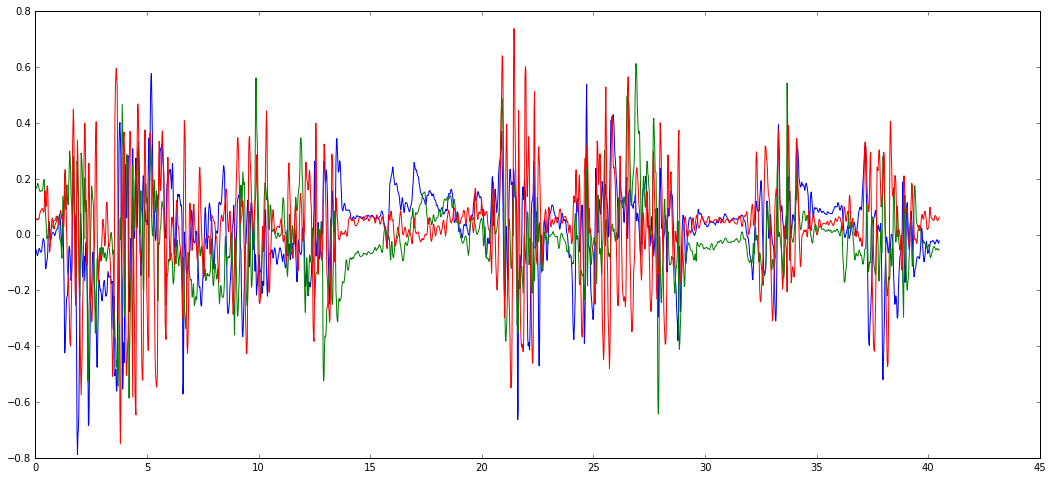

In [29]:
allAccX = []
allAccY = []
allAccZ = []
time_interval = 0
for i, w in enumerate(wFrames):
    if i==0:
        for x, y, z in zip(w['accX'].dropna().as_matrix(), w['accY'].dropna().as_matrix(), w['accZ'].dropna().as_matrix()):
            allAccX.append(x/16384.0)
            allAccY.append(y/16384.0)
            allAccZ.append(z/16384.0)
    else:
        values = list(set(w['time']) - set(wFrames[i-1]['time']))
        time_interval = w['time'].iloc[-1]
        result = w[w['time'].isin(values)]
        for x, y, z in zip(result['accX'].dropna().as_matrix(), result['accY'].dropna().as_matrix(), result['accZ'].dropna().as_matrix()):
            allAccX.append(x/16384.0)
            allAccY.append(y/16384.0)
            allAccZ.append(z/16384.0)
            
N_samps = len(allAccX)
Fs = N_samps/time_interval
print "Time interval: ", str(time_interval)
# the period represents the oscilation. It's  the sample time, the time after which each data come.
T = 1./Fs

t  = np.linspace(0,N_samps*T,N_samps) # N_samps*T (#samples x sample period) is the signal time.

fig, ax = plt.subplots(1,1, figsize=(18,8))
ax.plot(t,allAccX)
ax.plot(t,allAccY)
ax.plot(t,allAccZ)

In [30]:
def running_mean(l, N):
    # Also works for the(strictly invalid) cases when N is even.
    if (N//2)*2 == N:
        N = N - 1
    front = np.zeros(N//2)
    back = np.zeros(N//2)

    for i in range(1, (N//2)*2, 2):
        front[i//2] = np.convolve(l[:i], np.ones((i,))/i, mode = 'valid')
    for i in range(1, (N//2)*2, 2):
        back[i//2] = np.convolve(l[-i:], np.ones((i,))/i, mode = 'valid')
    return np.concatenate([front, np.convolve(l, np.ones((N,))/N, mode = 'valid'), back[::-1]])

def compute_runavg_acc(data, suptitle="Running average smoothing", feature='activity', N=4):
    """Running average as smoothing"""
    fig, ax = plt.subplots(1,1, figsize=(18,8))

    ## According to the MPU-6050 datasheet, page 13, you can convert the raw accelerometer
    # data into multiples of g (9.8 m/s^2) by dividing by a factor of 16384. 
    norm_dataX = running_mean(data, N)
    
    N_samps = len(norm_dataX)
    Fs = N_samps/time_interval
    print "Time interval: ", str(time_interval)
    # the period represents the oscilation. It's  the sample time, the time after which each data come.
    T = 1./Fs

    t  = np.linspace(0,N_samps*T,N_samps) # N_samps*T (#samples x sample period) is the signal time.
    
    ax.set_ylabel('g\'s (9.8 m/s^2)')
    ax.plot(norm_dataX)
    ax.grid()
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3, fontsize=8, fancybox=True, shadow=True)
                
    plt.draw()
    return norm_dataX

Time interval:  40.49


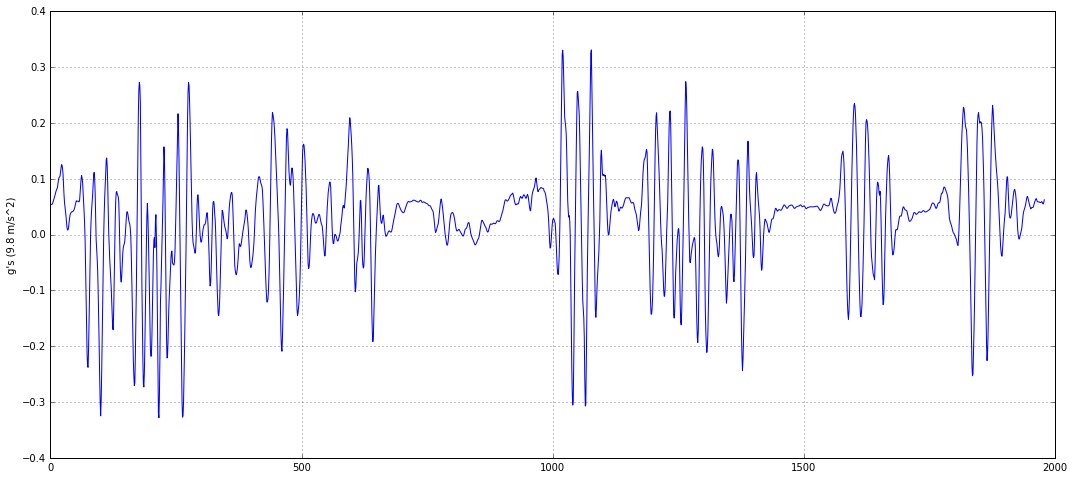

In [31]:
mnormalized = compute_runavg_acc(allAccZ, N=12)
vect = np.array(mnormalized)
sio.savemat('znormalized.mat', {'vect':vect})

In [42]:
import online_chan_detector as oncd
from functools import partial

data = mnormalized
R, maxes = oncd.online_changepoint_detection(data, partial(oncd.constant_hazard, 250), oncd.StudentT(0.1, .01, 1, 0))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


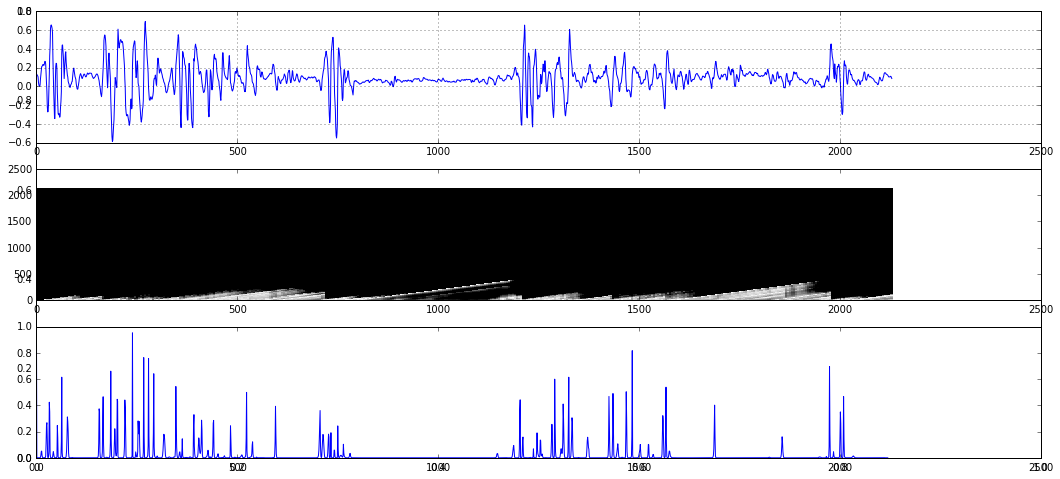

In [43]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=[18, 8])
ax = fig.add_subplot(3, 1, 1)
ax.plot(data)
ax.grid()
ax1 = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 5 # only plot every fifth data for faster display
ax1.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax2 = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax2.plot(R[Nw,Nw:-1])